In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Plotly requirements
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Machine learning models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.cross_validation import KFold

# Additions
import warnings
warnings.filterwarnings('ignore')

In [2]:
orders_path = '../orders_churn.csv'

df = pd.read_csv(orders_path)

In [3]:
def show_model_performance(name, y_pred, y_score): 
    mycolors = [[0.0, 'rgb(165,0,38)'],
                  [0.1111111111111111, 'rgb(215,48,39)'],
                  [0.2222222222222222, 'rgb(244,109,67)'],
                  [0.3333333333333333, 'rgb(253,174,97)'],
                  [0.4444444444444444, 'rgb(254,224,144)'],
                  [0.5555555555555556, 'rgb(224,243,248)'],
                  [0.6666666666666666, 'rgb(171,217,233)'],
                  [0.7777777777777778, 'rgb(116,173,209)'],
                  [0.8888888888888888, 'rgb(69,117,180)'],
                  [1.0, 'rgb(49,54,149)']]
    
    #plot confusion matrix
    conf_matrix = confusion_matrix(target_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = mycolors, showscale  = False)

    #get metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    #plot metrix barPlot
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #plot ROC-curve
    model_roc_auc = round(roc_auc_score(target_test, y_score) , 3)
    fpr, tpr, t = roc_curve(target_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('lightskyblue'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #plot Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(target_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('gold'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                        subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+name,
                        autosize = False, height = 900,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [4]:
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': list(df), 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(30)
    plt.figure(figsize = (10,12))
    plt.title('Top 30 - Features importance',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [5]:
# Def X and Y
y = np.array(df.Churn.tolist())
df = df.drop('Churn', 1)
X = np.array(df.as_matrix())

In [6]:
# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_test = train_test_split(X, y, train_size= 0.75)

In [7]:
#Since there is a severe imbalance in the values within the target variable, 
#I will use the SMOTE method in the dealing with this skewed value via the imblearn Python package.

oversampler = SMOTE(random_state=0)
smote_train, smote_target_train = oversampler.fit_sample(train,target_train)

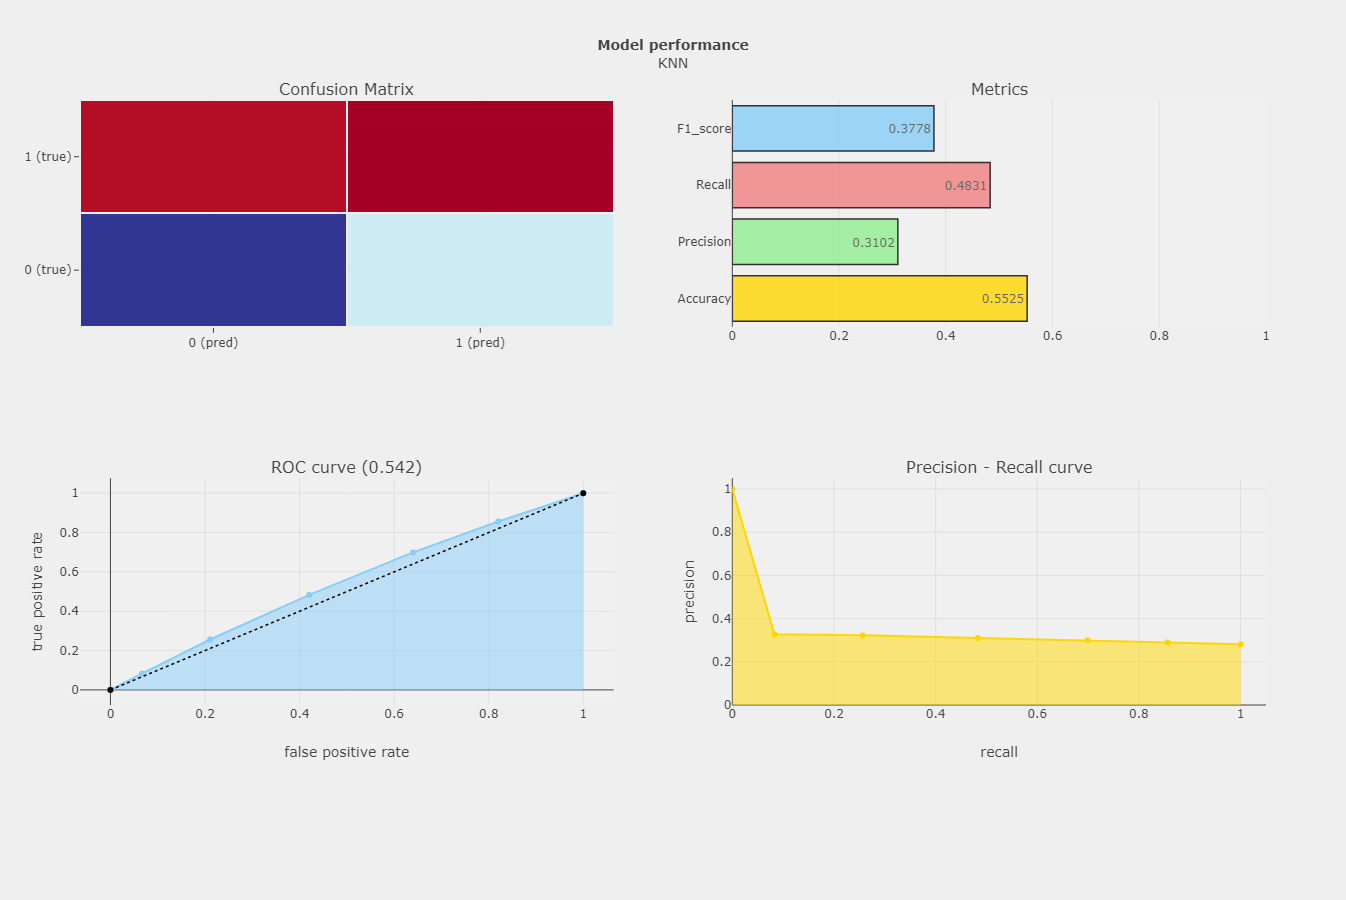

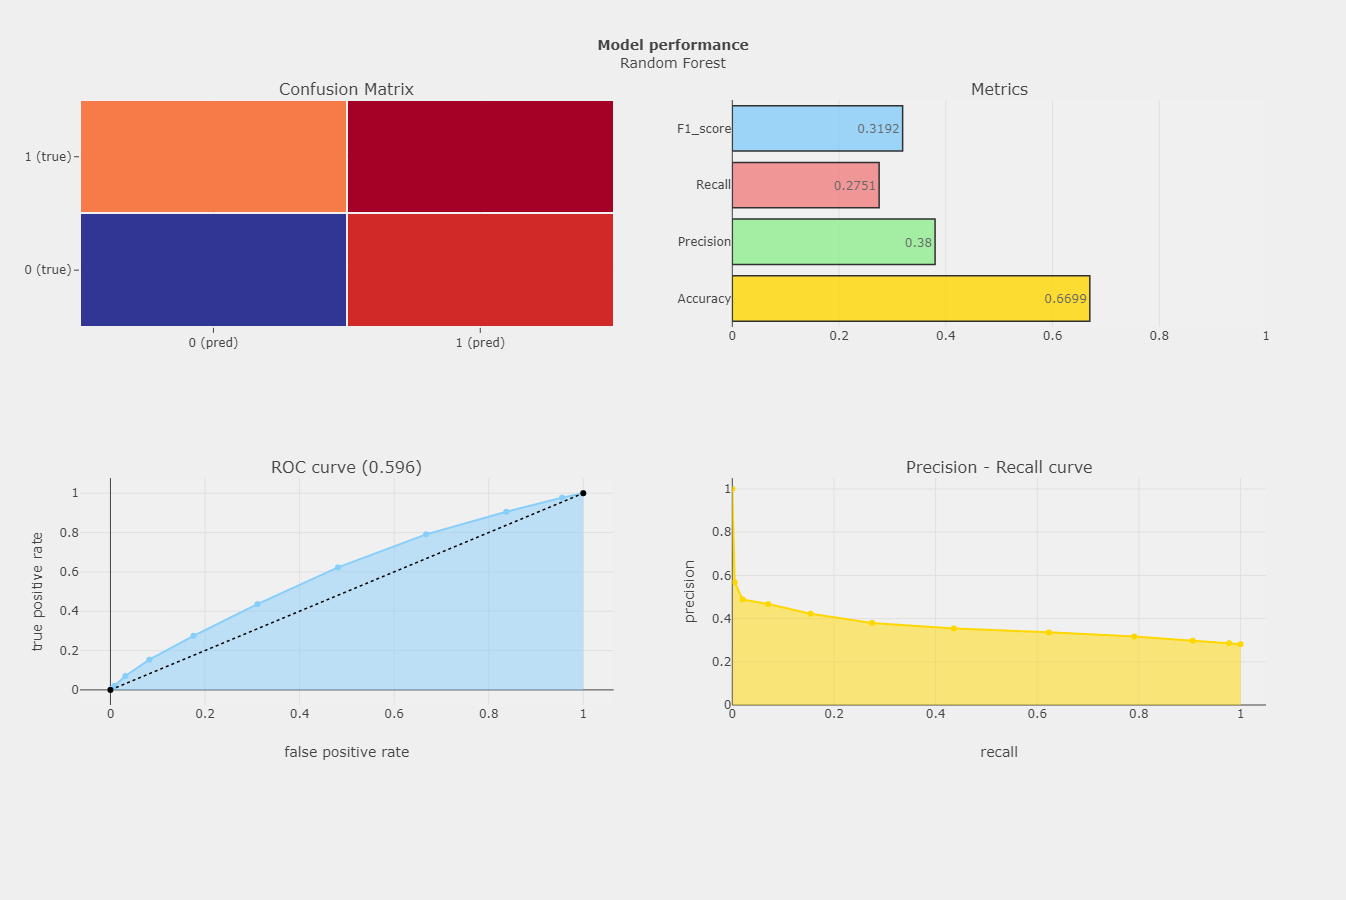

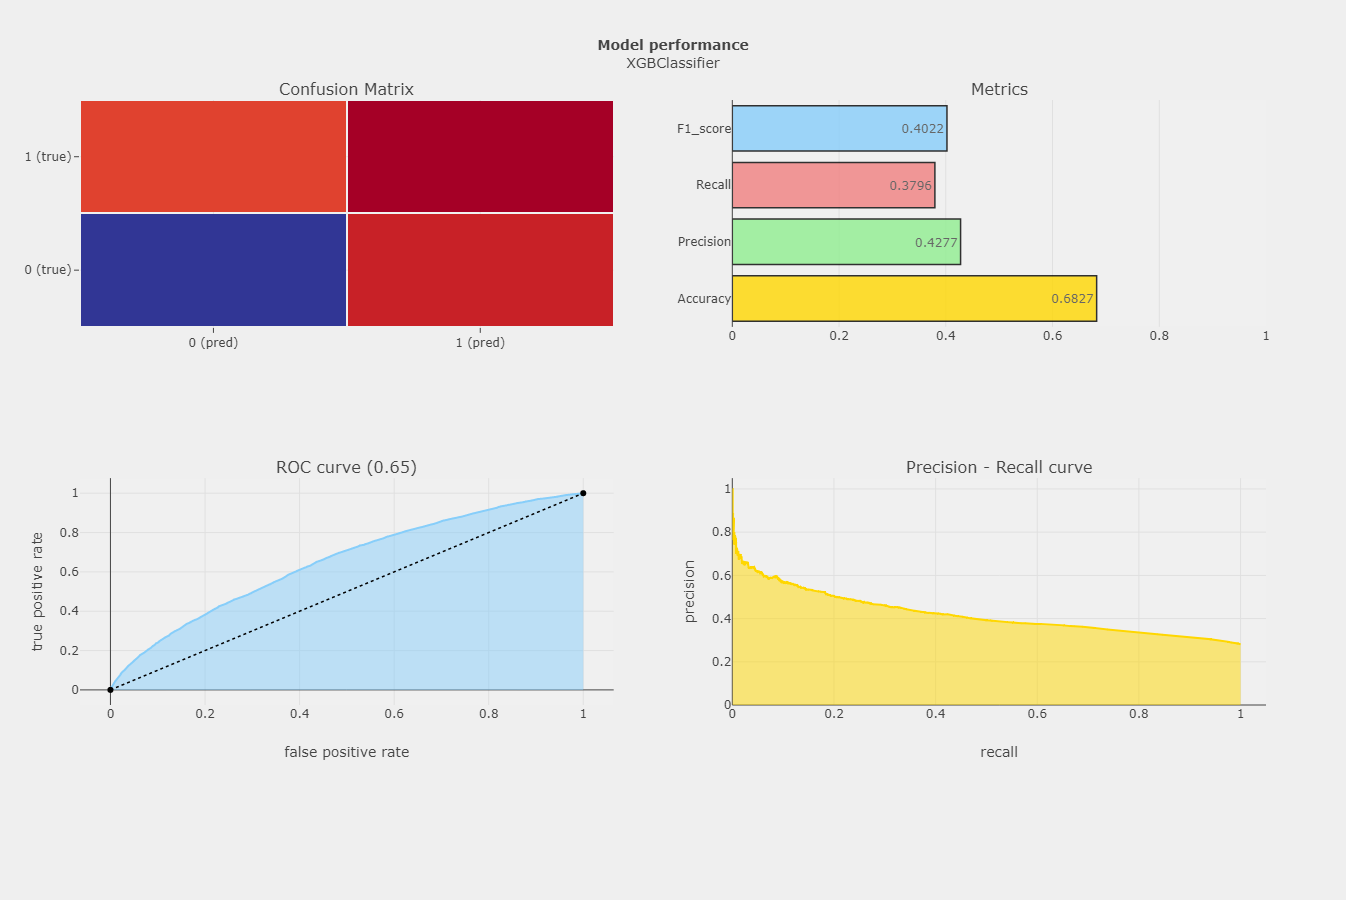

In [8]:
models=[]
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBClassifier', xgb.XGBClassifier()))

for name,model in models:
    model.fit(smote_train, smote_target_train)
    predictions = model.predict(test)
    y_score = model.predict_proba(test)[:,1]
    show_model_performance(name, predictions, y_score)